In [870]:
import pandas as pd

In [871]:
df = pd.read_csv("/content/payette_streamflow.txt", sep='\t', header=None)

In [872]:
payette_df = df.drop(columns=[0,1, 4,5,6,7,8,9,10])

In [873]:
payette_df.rename(columns={0: "x", 1: "y"})

,2,3
0,1987-01-01,272
1,1987-01-02,290
2,1987-01-03,296
3,1987-01-04,291
4,1987-01-05,282
...,...,...
12293,2020-08-28,408
12294,2020-08-29,398
12295,2020-08-30,391
12296,2020-08-31,394


In [874]:
features_df = pd.read_csv("/content/climate_data_payette.csv", error_bad_lines=False)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (7,23) have mixed types.Specify dtype option on import or set low_memory=False.



In [875]:
print(features_df)

           STATION                  NAME  ...  WSFI  WSFI_ATTRIBUTES
0      USS0015E09S   JACKSON PEAK, ID US  ...   NaN              NaN
1      USS0015E09S   JACKSON PEAK, ID US  ...   NaN              NaN
2      USS0015E09S   JACKSON PEAK, ID US  ...   NaN              NaN
3      USS0015E09S   JACKSON PEAK, ID US  ...   NaN              NaN
4      USS0015E09S   JACKSON PEAK, ID US  ...   NaN              NaN
...            ...                   ...  ...   ...              ...
36881  USS0015E11S  BANNER SUMMIT, ID US  ...   NaN              NaN
36882  USS0015E11S  BANNER SUMMIT, ID US  ...   NaN              NaN
36883  USS0015E11S  BANNER SUMMIT, ID US  ...   NaN              NaN
36884  USS0015E11S  BANNER SUMMIT, ID US  ...   NaN              NaN
36885  USS0015E11S  BANNER SUMMIT, ID US  ...   NaN              NaN

[36886 rows x 24 columns]


In [876]:
features_df

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WESD,WESD_ATTRIBUTES,WSFI,WSFI_ATTRIBUTES
0,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-01,NaN,NaN,1.4,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,",,T",7.0,",,T",NaN,NaN
1,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-02,NaN,NaN,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,",,T",7.0,",,T",NaN,NaN
2,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-03,NaN,NaN,0.5,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,",,T",7.3,",,T",NaN,NaN
3,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-04,NaN,NaN,0.1,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,",,T",7.4,",,T",NaN,NaN
4,USS0015E09S,"JACKSON PEAK, ID US",44.05,-115.44,2154.9,1987-01-05,NaN,NaN,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,",,T",7.4,",,T",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36881,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,2020-08-26,NaN,NaN,0.2,",,T",0.0,",,T",59.0,",,T",77.0,",,T",44.0,",,T",49.0,",,T",0.0,",,T",NaN,NaN
36882,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,2020-08-27,NaN,NaN,0.0,",,T",0.0,",,T",55.0,",,T",72.0,",,T",44.0,",,T",44.0,",,T",0.0,",,T",NaN,NaN
36883,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,2020-08-28,NaN,NaN,0.0,",,T",0.0,",,T",56.0,",,T",75.0,",,T",42.0,",,T",44.0,",,T",0.0,",,T",NaN,NaN
36884,USS0015E11S,"BANNER SUMMIT, ID US",44.30,-115.23,2145.8,2020-08-29,NaN,NaN,0.0,",,T",0.0,",,T",56.0,",,T",76.0,",,T",38.0,",,T",41.0,",,T",0.0,",,T",NaN,NaN


In [877]:
## Let's just use Banner Summit for simplicity's sake

In [878]:
banner_df = features_df[features_df['NAME']=='BANNER SUMMIT, ID US']

In [879]:
banner_df

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WESD,WESD_ATTRIBUTES,WSFI,WSFI_ATTRIBUTES
24591,USS0015E11S,"BANNER SUMMIT, ID US",44.3,-115.23,2145.8,1987-01-01,NaN,NaN,0.9,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,",,T",6.8,",,T",NaN,NaN
24592,USS0015E11S,"BANNER SUMMIT, ID US",44.3,-115.23,2145.8,1987-01-02,NaN,NaN,0.1,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,",,T",6.8,",,T",NaN,NaN
24593,USS0015E11S,"BANNER SUMMIT, ID US",44.3,-115.23,2145.8,1987-01-03,NaN,NaN,0.4,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,",,T",7.4,",,T",NaN,NaN
24594,USS0015E11S,"BANNER SUMMIT, ID US",44.3,-115.23,2145.8,1987-01-04,NaN,NaN,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,",,T",7.4,",,T",NaN,NaN
24595,USS0015E11S,"BANNER SUMMIT, ID US",44.3,-115.23,2145.8,1987-01-05,NaN,NaN,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,",,T",7.4,",,T",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36881,USS0015E11S,"BANNER SUMMIT, ID US",44.3,-115.23,2145.8,2020-08-26,NaN,NaN,0.2,",,T",0.0,",,T",59.0,",,T",77.0,",,T",44.0,",,T",49.0,",,T",0.0,",,T",NaN,NaN
36882,USS0015E11S,"BANNER SUMMIT, ID US",44.3,-115.23,2145.8,2020-08-27,NaN,NaN,0.0,",,T",0.0,",,T",55.0,",,T",72.0,",,T",44.0,",,T",44.0,",,T",0.0,",,T",NaN,NaN
36883,USS0015E11S,"BANNER SUMMIT, ID US",44.3,-115.23,2145.8,2020-08-28,NaN,NaN,0.0,",,T",0.0,",,T",56.0,",,T",75.0,",,T",42.0,",,T",44.0,",,T",0.0,",,T",NaN,NaN
36884,USS0015E11S,"BANNER SUMMIT, ID US",44.3,-115.23,2145.8,2020-08-29,NaN,NaN,0.0,",,T",0.0,",,T",56.0,",,T",76.0,",,T",38.0,",,T",41.0,",,T",0.0,",,T",NaN,NaN


In [880]:
banner_df.isnull().sum()

STATION                0
NAME                   0
LATITUDE               0
LONGITUDE              0
ELEVATION              0
DATE                   0
AWND               12295
AWND_ATTRIBUTES    12295
PRCP                   2
PRCP_ATTRIBUTES        2
SNWD                5139
SNWD_ATTRIBUTES     5139
TAVG                 527
TAVG_ATTRIBUTES      527
TMAX                 526
TMAX_ATTRIBUTES      526
TMIN                 535
TMIN_ATTRIBUTES      535
TOBS                  75
TOBS_ATTRIBUTES       75
WESD                   4
WESD_ATTRIBUTES        4
WSFI               12295
WSFI_ATTRIBUTES    12295
dtype: int64

In [881]:
banner_df.shape

(12295, 24)

In [882]:
banner_df.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND',
       'AWND_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES',
       'TAVG', 'TAVG_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN',
       'TMIN_ATTRIBUTES', 'TOBS', 'TOBS_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES',
       'WSFI', 'WSFI_ATTRIBUTES'],
      dtype='object')

In [883]:
null_columns = ['AWND', 'AWND_ATTRIBUTES', 'WSFI', 'WSFI_ATTRIBUTES']

In [884]:
banner_df = banner_df.drop(columns=null_columns)

In [885]:
constant_columns = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']

In [886]:
banner_df = banner_df.drop(columns=constant_columns)

In [887]:
banner_df

,DATE,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WESD,WESD_ATTRIBUTES
24591,1987-01-01,0.9,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,",,T",6.8,",,T"
24592,1987-01-02,0.1,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,",,T",6.8,",,T"
24593,1987-01-03,0.4,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,",,T",7.4,",,T"
24594,1987-01-04,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,",,T",7.4,",,T"
24595,1987-01-05,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,",,T",7.4,",,T"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36881,2020-08-26,0.2,",,T",0.0,",,T",59.0,",,T",77.0,",,T",44.0,",,T",49.0,",,T",0.0,",,T"
36882,2020-08-27,0.0,",,T",0.0,",,T",55.0,",,T",72.0,",,T",44.0,",,T",44.0,",,T",0.0,",,T"
36883,2020-08-28,0.0,",,T",0.0,",,T",56.0,",,T",75.0,",,T",42.0,",,T",44.0,",,T",0.0,",,T"
36884,2020-08-29,0.0,",,T",0.0,",,T",56.0,",,T",76.0,",,T",38.0,",,T",41.0,",,T",0.0,",,T"


In [888]:
payette_df.columns

Int64Index([2, 3], dtype='int64')

In [889]:
payette_df.columns = ['DATE', 'STREAMFLOW']

In [890]:
payette_df

,DATE,STREAMFLOW
0,1987-01-01,272
1,1987-01-02,290
2,1987-01-03,296
3,1987-01-04,291
4,1987-01-05,282
...,...,...
12293,2020-08-28,408
12294,2020-08-29,398
12295,2020-08-30,391
12296,2020-08-31,394


In [891]:
banner_df = banner_df.merge(payette_df, left_on='DATE', right_on='DATE')
#df1.merge(df2, left_on='lkey', right_on='rkey')

In [892]:
import matplotlib.pyplot as plt

In [893]:
type(banner_df['DATE'][0])

str

In [894]:
banner_df['DATE'] = pd.to_datetime(banner_df['DATE'])

In [895]:
type(banner_df['DATE'][0])

pandas._libs.tslibs.timestamps.Timestamp

Here we're going to do some feature engineering. I want to get the 'day of year' from the datetime object.

In [896]:
banner_df['DAY_OF_YEAR'] = banner_df['DATE'].dt.dayofyear

In [897]:
banner_df

,DATE,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WESD,WESD_ATTRIBUTES,STREAMFLOW,DAY_OF_YEAR
0,1987-01-01,0.9,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,",,T",6.8,",,T",272,1
1,1987-01-02,0.1,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,",,T",6.8,",,T",290,2
2,1987-01-03,0.4,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,",,T",7.4,",,T",296,3
3,1987-01-04,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,",,T",7.4,",,T",291,4
4,1987-01-05,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,",,T",7.4,",,T",282,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12290,2020-08-26,0.2,",,T",0.0,",,T",59.0,",,T",77.0,",,T",44.0,",,T",49.0,",,T",0.0,",,T",413,239
12291,2020-08-27,0.0,",,T",0.0,",,T",55.0,",,T",72.0,",,T",44.0,",,T",44.0,",,T",0.0,",,T",417,240
12292,2020-08-28,0.0,",,T",0.0,",,T",56.0,",,T",75.0,",,T",42.0,",,T",44.0,",,T",0.0,",,T",408,241
12293,2020-08-29,0.0,",,T",0.0,",,T",56.0,",,T",76.0,",,T",38.0,",,T",41.0,",,T",0.0,",,T",398,242


In [898]:
#banner_df['DATE'][1000].strftime('%-j')

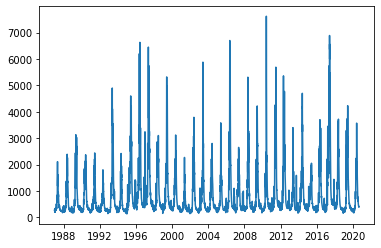

In [899]:
plt.plot(banner_df['DATE'], banner_df['STREAMFLOW']);

In [900]:
import plotly.express as px

In [901]:
px.scatter(
    banner_df,
    x='DATE',
    y='STREAMFLOW')

In [902]:
px.scatter(
    banner_df,
    x='DAY_OF_YEAR',
    y='STREAMFLOW')

Let's start with the baseline. If we just predicted the mean streamflow, it would be about 800 cfs.

In [903]:
baseline_prediction = banner_df['STREAMFLOW'].mean()
print(baseline_prediction)

799.9204554697031


Now I'm going to create a simple linear model.

In [904]:
from sklearn.linear_model import LinearRegression

In [905]:
model = LinearRegression()

First, I'll break the data into train and test sets.

We'll train on the years 1987-2015 and test on the years 2016-2020.


In [906]:
train_df = banner_df[banner_df['DATE'].dt.year <= 2015]
test_df = banner_df[banner_df['DATE'].dt.year > 2015]

In [907]:
print(train_df.shape)
print(test_df.shape)

(10592, 17)
(1703, 17)


In [908]:
features = ['DAY_OF_YEAR']
target = 'STREAMFLOW'

In [909]:
x_train = train_df[features]
y_train = train_df[target]
x_test = test_df[features]
y_test = test_df[target]

In [910]:
print(f'Linear Regression, dependent on: {features}')

Linear Regression, dependent on: ['DAY_OF_YEAR']


In [911]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [912]:
from sklearn.metrics import mean_absolute_error

In [913]:
y_pred = model.predict(x_test)

In [914]:
mae_one_feature = mean_absolute_error(y_test, y_pred)

In [915]:
print(f'MEAN ABSOLUTE ERROR: {mae_one_feature:,.0f} CFS')

MEAN ABSOLUTE ERROR: 685 CFS


When we do a linear regression with one feature, the day of the year, the MAE is 685 cfs.


How does that compare to just guessing the average flow?


In [916]:
mae_baseline = mean_absolute_error(y_test, [baseline_prediction]*len(y_test))

In [917]:
print(f'MEAN ABSOLUTE ERROR: {mae_baseline:,.0f} CFS')

MEAN ABSOLUTE ERROR: 712 CFS


It's slightly better - 27 cfs better on average- but that's still not great. 600 + cfs is a lot to get the flow estimation wrong by, especially because the average flow is 800 cfs!

That would be almost like guessing that the river is empty or twice the current flow, most of the time.

In [918]:
diff_from_baseline = mae_baseline - mae_one_feature
print(f'Model error improvement from baseline: {diff_from_baseline:,.0f} CFS')

Model error improvement from baseline: 27 CFS


Let's also look at the R^2 score


In [919]:
from sklearn.metrics import r2_score

In [920]:
r2_baseline = r2_score(y_test, [baseline_prediction]*len(y_test))
print(r2_baseline)

-0.030307849670689224


In [921]:
r2_one_feature = r2_score(y_test, y_pred)
print(r2_one_feature)

-0.013160718374388036


## Now it's time to add some more features into this model.


In [922]:
banner_df

,DATE,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WESD,WESD_ATTRIBUTES,STREAMFLOW,DAY_OF_YEAR
0,1987-01-01,0.9,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,",,T",6.8,",,T",272,1
1,1987-01-02,0.1,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,",,T",6.8,",,T",290,2
2,1987-01-03,0.4,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,",,T",7.4,",,T",296,3
3,1987-01-04,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,",,T",7.4,",,T",291,4
4,1987-01-05,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,",,T",7.4,",,T",282,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12290,2020-08-26,0.2,",,T",0.0,",,T",59.0,",,T",77.0,",,T",44.0,",,T",49.0,",,T",0.0,",,T",413,239
12291,2020-08-27,0.0,",,T",0.0,",,T",55.0,",,T",72.0,",,T",44.0,",,T",44.0,",,T",0.0,",,T",417,240
12292,2020-08-28,0.0,",,T",0.0,",,T",56.0,",,T",75.0,",,T",42.0,",,T",44.0,",,T",0.0,",,T",408,241
12293,2020-08-29,0.0,",,T",0.0,",,T",56.0,",,T",76.0,",,T",38.0,",,T",41.0,",,T",0.0,",,T",398,242


In [923]:
px.scatter(
    banner_df,
    x='PRCP',
    y='STREAMFLOW')

In [924]:
px.scatter(
    banner_df,
    x='TAVG',
    y='STREAMFLOW')

The TAVG, temperature average, looks like it will have some predictive value.

In [925]:
banner_df[banner_df['TAVG'].isnull()]

,DATE,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WESD,WESD_ATTRIBUTES,STREAMFLOW,DAY_OF_YEAR
0,1987-01-01,0.9,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,",,T",6.8,",,T",272,1
1,1987-01-02,0.1,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,",,T",6.8,",,T",290,2
2,1987-01-03,0.4,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,",,T",7.4,",,T",296,3
3,1987-01-04,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,",,T",7.4,",,T",291,4
4,1987-01-05,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,",,T",7.4,",,T",282,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3839,1997-07-06,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,",,T",2570,187
3968,1997-11-12,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,",,T",402,316
4585,1999-07-22,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,",,T",1020,203
4950,2000-07-21,0.0,",,T",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,",,T",557,203


I want to use the 'TAVG' or Temperature Average feature, but there are NaNs in it. I'm going to have to impute the average value for those 527 observations that are missing TAVG.


In [926]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()

In [927]:
features = ['DAY_OF_YEAR', 'TAVG']
target = 'STREAMFLOW'

In [928]:
x_train = train_df[features]
y_train = train_df[target]
x_test = test_df[features]
y_test = test_df[target]

In [929]:
print(f'Linear Regression, dependent on: {features}')

Linear Regression, dependent on: ['DAY_OF_YEAR', 'TAVG']


In [930]:
x_train = imputer.fit_transform(x_train)

In [931]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [932]:
from sklearn.metrics import mean_absolute_error

In [933]:
y_pred = model.predict(x_test)

In [934]:
mae_two_features = mean_absolute_error(y_test, y_pred)

In [935]:
print(f'MEAN ABSOLUTE ERROR: {mae_two_features:,.0f} CFS')

MEAN ABSOLUTE ERROR: 647 CFS


When we do a linear regression with two features, the day of the year and the average temperature, the MAE is 647 cfs.


In [936]:
diff_from_baseline = mae_baseline - mae_two_features
print(f'Model error improvement from baseline: {diff_from_baseline:,.0f} CFS')

Model error improvement from baseline: 66 CFS


Doing a little better- the improvement is up to 66 cfs

Let's also look at the R^2 score


In [937]:
r2_two_features = r2_score(y_test, y_pred)
print(r2_two_features)

0.10222464074087567


In [938]:
different_model_mae = {'Model Type': ['Baseline', '1 feature', '2 features'], 'MAE': [mae_baseline, mae_one_feature, mae_two_features], 'R^2':[r2_baseline, r2_one_feature, r2_two_features]}

In [939]:
mae_df = pd.DataFrame(different_model_mae)

In [940]:
mae_df

,Model Type,MAE,R^2
0,Baseline,712.227827,-0.030308
1,1 feature,684.879582,-0.013161
2,2 features,646.533264,0.102225


In [941]:
px.line(mae_df, x='Model Type', y='R^2')

## OK, now I'm just going to throw the kitchen sink at the problem. Let's use ALL the features from the NOAA dataset.


In [942]:
column_list = banner_df.columns.drop('STREAMFLOW')

In [943]:
column_list = banner_df.columns.drop('DATE')

In [944]:
print(column_list)

Index(['PRCP', 'PRCP_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 'TAVG',
       'TAVG_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES',
       'TOBS', 'TOBS_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES', 'STREAMFLOW',
       'DAY_OF_YEAR'],
      dtype='object')


In [945]:
banner_df.dtypes

DATE               datetime64[ns]
PRCP                      float64
PRCP_ATTRIBUTES            object
SNWD                      float64
SNWD_ATTRIBUTES            object
TAVG                      float64
TAVG_ATTRIBUTES            object
TMAX                      float64
TMAX_ATTRIBUTES            object
TMIN                      float64
TMIN_ATTRIBUTES            object
TOBS                      float64
TOBS_ATTRIBUTES            object
WESD                      float64
WESD_ATTRIBUTES            object
STREAMFLOW                  int64
DAY_OF_YEAR                 int64
dtype: object

In [946]:
banner_df.dtypes == object

DATE               False
PRCP               False
PRCP_ATTRIBUTES     True
SNWD               False
SNWD_ATTRIBUTES     True
TAVG               False
TAVG_ATTRIBUTES     True
TMAX               False
TMAX_ATTRIBUTES     True
TMIN               False
TMIN_ATTRIBUTES     True
TOBS               False
TOBS_ATTRIBUTES     True
WESD               False
WESD_ATTRIBUTES     True
STREAMFLOW         False
DAY_OF_YEAR        False
dtype: bool

In [947]:
object_list = ['PRCP_ATTRIBUTES','SNWD_ATTRIBUTES','TAVG_ATTRIBUTES','TMAX_ATTRIBUTES','TMIN_ATTRIBUTES','TOBS_ATTRIBUTES','WESD_ATTRIBUTES']

In [948]:
features = column_list
target = 'STREAMFLOW'

In [949]:
features = ['PRCP','SNWD','TAVG','TMAX','TMIN','TOBS','WESD','DAY_OF_YEAR']

In [950]:
x_train = train_df[features]
y_train = train_df[target]
x_test = test_df[features]
y_test = test_df[target]

In [951]:
print(f'Linear Regression, dependent on: {features}')

Linear Regression, dependent on: ['PRCP', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WESD', 'DAY_OF_YEAR']


In [952]:
x_train = imputer.fit_transform(x_train)
x_test = imputer.fit_transform(x_test)

# imputer = SimpleImputer(missing_values = np.nan,  
#                         strategy ='mean') 

In [953]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [954]:
import numpy as np
np.any(np.isnan(x_train))

False

In [955]:
np.any(np.isnan(x_test))

False

In [956]:
np.all(np.isfinite(x_train))

True

In [957]:
from sklearn.metrics import mean_absolute_error

In [958]:
y_pred = model.predict(x_test)

In [959]:
mae_eight_features = mean_absolute_error(y_test, y_pred)

In [960]:
print(f'MEAN ABSOLUTE ERROR: {mae_eight_features:,.0f} CFS')

MEAN ABSOLUTE ERROR: 620 CFS


When we do a linear regression with eight features, the MAE is 620 cfs.


In [961]:
diff_from_baseline = mae_baseline - mae_eight_features
print(f'Model error improvement from baseline: {diff_from_baseline:,.0f} CFS')

Model error improvement from baseline: 92 CFS


Doing a little better- the improvement is up to 92 cfs

Let's also look at the R^2 score


In [962]:
r2_eight_features = r2_score(y_test, y_pred)
print(r2_eight_features)

0.15336111663900143


In [963]:
different_model_mae = {'Model Type': ['Baseline', '1 feature', '2 features','8 features'], 'MAE': [mae_baseline, mae_one_feature, mae_two_features, mae_eight_features], 'R^2':[r2_baseline, r2_one_feature, r2_two_features, r2_eight_features]}

In [964]:
mae_df = pd.DataFrame(different_model_mae)

In [965]:
mae_df

,Model Type,MAE,R^2
0,Baseline,712.227827,-0.030308
1,1 feature,684.879582,-0.013161
2,2 features,646.533264,0.102225
3,8 features,620.477910,0.153361


In [966]:
px.line(mae_df, x='Model Type', y='R^2')

## Now I'm going to try training a random forest model on the dataset

In [970]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [976]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [977]:
mae_random_forest = mean_absolute_error(y_test, y_pred)
print(f'MEAN ABSOLUTE ERROR: {mae_random_forest:,.0f} CFS')

MEAN ABSOLUTE ERROR: 311 CFS


In [978]:
r2_random_forest = r2_score(y_test, y_pred)
print(r2_random_forest)

0.6782206510434056


In [979]:
different_model_mae = {'Model Type': ['Baseline', '1 feature', '2 features','8 features','random forest'], 'MAE': [mae_baseline, mae_one_feature, mae_two_features, mae_eight_features, mae_random_forest], 'R^2':[r2_baseline, r2_one_feature, r2_two_features, r2_eight_features, r2_random_forest]}

In [980]:
mae_df = pd.DataFrame(different_model_mae)

In [981]:
mae_df

,Model Type,MAE,R^2
0,Baseline,712.227827,-0.030308
1,1 feature,684.879582,-0.013161
2,2 features,646.533264,0.102225
3,8 features,620.477910,0.153361
4,random forest,311.494240,0.678221


## Wow, the random forest works a lot better! This is without any hyperparameter tuning, also.

In [982]:
px.line(mae_df, x='Model Type', y='R^2')

## And now, let's throw this in a LSTM neural network

In [983]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [985]:
x_train = train_df[features]
y_train = train_df[target]
x_test = test_df[features]
y_test = test_df[target]

In [986]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [987]:

# # convert an array of values into a dataset matrix
# def create_dataset(dataset, look_back=1):
# 	dataX, dataY = [], []
# 	for i in range(len(dataset)-look_back-1):
# 		a = dataset[i:(i+look_back), 0]
# 		dataX.append(a)
# 		dataY.append(dataset[i + look_back, 0])
# 	return numpy.array(dataX), numpy.array(dataY)

## Export the model so I can deploy on Heroku


In [967]:
from joblib import dump
dump(model, 'model.joblib', compress=True)

['model.joblib']

In [968]:
## to do:
'''
try a simple neural network to predict streamflow

try a LSTM neural network to predict streamflow
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

incorporate nested cross validation (used for time series data)

------

ingest more data:
-1+ more stations from in the basin
-satellite imagery from Google Earth Engine (but would have to get daily imagery- tough?)
- or get it from Planet. Weekly imagery might have to do. Compress to low-res if possible

'''

'\n#clean the banner_df, remove attributes with null values\nno, impute the NaN values\n\ntry a linear regression with ALL the features\n\n\ntry a random forest to predict streamflow\ntry a simple neural network to predict streamflow\n\ntry a LSTM neural network to predict streamflow\n\nincorporate nested cross validation (used for time series data)\n\n------\n\ningest more data:\n-1+ more stations from in the basin\n-satellite imagery from Google Earth Engine (but would have to get daily imagery- tough?)\n- or get it from Planet. Weekly imagery might have to do. Compress to low-res if possible\n\n'